In [2]:
import re
import string
import numpy as np
import pandas as pd

In [3]:
import keras

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
import tensorflow

In [6]:
tensorflow.__version__

'2.8.0'

In [7]:
keras.__version__

'2.8.0'

In [8]:
df = pd.read_csv("turkish_movie_sentiment_dataset.csv/turkish_movie_sentiment_dataset.csv")

In [9]:
df.head()

,comment,film_name,point
0,\n Jean Reno denince zate...,Sevginin Gücü,"5,0"
1,\n Ekşın falan izlemek is...,Sevginin Gücü,"5,0"
2,\n Bu yapım hakkında öyle...,Sevginin Gücü,"5,0"
3,\n finali yeter... (sting...,Sevginin Gücü,"5,0"
4,\n Jean Reno..\r\nbu adam...,Sevginin Gücü,"5,0"


In [10]:
df.sample(10)

,comment,film_name,point
14480,\n güzel bi film arkadaşl...,Utanç,"4,0"
68441,\n Son sahnesine kadar me...,Zaman Yolcuları,"3,5"
29869,\n Film inanılmaz güzeldi...,The Fall,"4,0"
61003,\n Dışarıdan bakıldığı gi...,Bu Nasıl Aile?,"3,0"
39235,\n Seneler sonra tekrar i...,Aslan Kral,"3,5"
80564,\n fena bir film değil oy...,"Big Bounce, The","3,0"
55502,\n filmi artı yönde bakma...,Otel,"1,0"
27071,\n az diyolog çok iş..we ...,Dönüş,"4,0"
77822,\n orta düzey bir film ol...,Off Karadeniz,"1,5"
26669,\n Buradaki tek mesaj; hayat b*k gibi bir yer...,Bisiklet Hırsızları,"4,0"


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83227 entries, 0 to 83226
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    83227 non-null  object
 1   film_name  83227 non-null  object
 2   point      83227 non-null  object
dtypes: object(3)
memory usage: 1.9+ MB


In [12]:
df.shape

(83227, 3)

### Özniteliklerin incelenmesi

In [17]:
df["comment"].nunique()

82456

In [13]:
df["comment"].unique()

array(['\n                      Jean Reno denince zaten leon filmi gelir akla izlemeyen kalmamıştır ama kaldıysada ee ne duruyorsun hemen izle :)\n        \n            ',
       '\n                      Ekşın falan izlemek istiyorsanız eğer bunu izlemeyiin dostlarım keza ilk sahne hariç ekşın filmde yerini gittikçe duygusallığa bırakır.. Mathildanın Leonun evine geldiğinde ağladığı sahnede ben de ağlamış olabilirim.. Tamam olabilirim değil ağladım; ama sen de izle ağlarsın dostooom. \r\nEtkileyici bir film, sıkmıyor hiçbir salise boyunca sizi.\r\n" Ben artık büyüdüm Leon, yaşlanıyorum. "\r\n" Hayat hep böyle zor mu, yoksa sadece çocukken mi? "\n        \n            ',
       '\n                      Bu yapım hakkında öyle çok şey yazabilirim ki kitap olur. O yüzden kısa kesmem lazım. Bir kere ağladığım iki filmden birisidir(diğeri = yeşil yol). İzlediğim en iyi film midir karar veremeyeceğim ama izlediğim en sanatsal sahneleri barındıran Luc Besson harikası olduğu kesindir. \r\n\r\nO

In [14]:
df["film_name"].unique()

array(['Sevginin Gücü', 'Teksas Katliamı 3D', 'Baba 3', ..., 'Marid',
       "Bir Zamanlar... Hollywood'da", 'Ölüm Bekçisi'], dtype=object)

In [15]:
df["film_name"].nunique()

7722

In [16]:
df["point"].unique()

array(['5,0', '3,5', '4,5', '2,5', '2,0', '3,0', '4,0', '1,5', '0,5',
       '1,0', '4,6', '3,9', '3,8', '3,7', '3,2', '3,1'], dtype=object)

In [17]:
df["point"].nunique()

16

In [18]:
df.columns

Index(['comment', 'film_name', 'point'], dtype='object')

Görüldüğü üzere yorumların hepsinin başında “\n” böyle bir karakter mevcuttur. Biz de bir fonksiyon yazarak bu karakterleri kaldıracağız.
Birkaç satır ile kontrol ettiğimde verinin başından 23 karakter ileri, sonundan da 24 karakter geri gittiğimde oluşmuş boşluklar ve “\n” karakterleri ortadan kalkıyor. O yüzden bunu tüm veriye uygulayabileceğimiz bir fonksiyon yazmamız gerekiyor.
Öncelikle comments adlı bir fonksiyon oluşturuyorum. Bu fonksiyon istediğimiz değişken içerisindeki gözlemlerin başından 23, sonundan 24 karakter kaldıracak. Ardından bu fonksiyonu comment değişkenindeki gözlemlere apply modülü ile tek tek uyguluyorum ve tekrar aynı değişken içerisine atıyorum.

In [24]:
comments = lambda x : x[23:-24]

df["comment"] = df["comment"].apply(comments)

In [25]:
df["comment"].head()

0    Jean Reno denince zaten leon filmi gelir akla ...
1    Ekşın falan izlemek istiyorsanız eğer bunu izl...
2    Bu yapım hakkında öyle çok şey yazabilirim ki ...
3    finali yeter... (sting - shape of my heart)\r\...
4    Jean Reno..\r\nbu adam kusursuz biri..\r\nve o...
Name: comment, dtype: object

Filmlere 1–5 arası puanlandırma yapılmıştır. Bizim duygu sınıflandırmamız pozitif ve negatif olarak ayrılacağı için bunu ikili sınıflandırmaya dönüştürmem gerekiyor. Fakat ondan önce bir sorun daha mevcut, veri içerisinde numaralar virgül ile ayrılmış. Biz sadece ilk karakteri alacağız ve ardından float tipine dönüştüreceğiz.

In [26]:
df["point"].value_counts()

4,0    19958
5,0    15873
2,5    11433
3,5     8565
4,5     6983
3,0     5499
0,5     5150
1,0     4917
2,0     2433
1,5     1464
4,6      522
3,9      211
3,8      100
3,7       55
3,2       38
3,1       26
Name: point, dtype: int64

In [27]:
floatize = lambda x : float(x[0:-2])
df["point"] = df["point"].apply(floatize)
df["point"].value_counts()

4.0    27463
5.0    15873
3.0    14494
2.0    13866
1.0     6381
0.0     5150
Name: point, dtype: int64

Düzelttiğimiz puanları, 0 ve 1 olarak sınıflandıracağız. 3 puanı bizim için nötr oluyor. Ne pozitif ne de negatif diyebiliyoruz. Bu satırları veriden çıkaracağız. Ardından 3'ten küçüklere 0 (negatif), 3'ten büyüklere 1 (pozitif) diye atama yapacağız.


In [28]:
df.drop(df[df["point"]== 3].index, inplace=True)

In [29]:
df["point"] = df["point"].replace(1,0)
df["point"] = df["point"].replace(2,0)
df["point"] = df["point"].replace(4,1)
df["point"] = df["point"].replace(5,1)
df["point"].value_counts()

1.0    43336
0.0    25397
Name: point, dtype: int64

Veri içerisinden sildiğimiz satırlar olduğu için index yapısı bozuldu. İndexleri resetliyoruz.

In [30]:
df.head()

,comment,film_name,point
0,Jean Reno denince zaten leon filmi gelir akla ...,Sevginin Gücü,1.0
1,Ekşın falan izlemek istiyorsanız eğer bunu izl...,Sevginin Gücü,1.0
2,Bu yapım hakkında öyle çok şey yazabilirim ki ...,Sevginin Gücü,1.0
3,finali yeter... (sting - shape of my heart)\r\...,Sevginin Gücü,1.0
4,Jean Reno..\r\nbu adam kusursuz biri..\r\nve o...,Sevginin Gücü,1.0


In [31]:
df.reset_index(inplace=True)
df.drop("index", axis = 1, inplace = True)
df.head()

,comment,film_name,point
0,Jean Reno denince zaten leon filmi gelir akla ...,Sevginin Gücü,1.0
1,Ekşın falan izlemek istiyorsanız eğer bunu izl...,Sevginin Gücü,1.0
2,Bu yapım hakkında öyle çok şey yazabilirim ki ...,Sevginin Gücü,1.0
3,finali yeter... (sting - shape of my heart)\r\...,Sevginin Gücü,1.0
4,Jean Reno..\r\nbu adam kusursuz biri..\r\nve o...,Sevginin Gücü,1.0


Yorumların ön işlemlerine geçiş yapıyoruz. İlk önce comments altındaki bütün karakterleri küçültüyoruz. Bunu lower modülü ile gerçekleştireceğiz. Apply modülü ile tüm veri içerisine uyguluyoruz.


In [32]:
df["comment"] = df["comment"].apply(lambda x: x.lower())
df.head()

,comment,film_name,point
0,jean reno denince zaten leon filmi gelir akla ...,Sevginin Gücü,1.0
1,ekşın falan izlemek istiyorsanız eğer bunu izl...,Sevginin Gücü,1.0
2,bu yapım hakkında öyle çok şey yazabilirim ki ...,Sevginin Gücü,1.0
3,finali yeter... (sting - shape of my heart)\r\...,Sevginin Gücü,1.0
4,jean reno..\r\nbu adam kusursuz biri..\r\nve o...,Sevginin Gücü,1.0


Şimdi ise noktalama işaretlerini kaldıracağız. remove_punctuation adlı bir fonksiyon yazıyoruz. Bu fonksiyon yorumlar içerisinde dolanacak ve eğer gezindiği karakter noktalama işareti değil ise bunu word_wo_punc değişkenine atacak. Ardından da biz bu apply modülü ile bunu veriye uygulayacağız ve bize veriyi noktalama işaretleri kaldırılmış bir şekilde verecek. Fakat bunu tek başına yaptığımızda içerisinde hala kalkmamış olan “\n” ve “\r” karakterleri yer alıyor. Bunu da kendimiz manuel olarak değiştiriyoruz.

In [33]:
def remove_punctuation(text):
    no_punc = [words for words in text if words not in string.punctuation]
    word_wo_punc = "".join(no_punc)
    return word_wo_punc

df["comment"] = df["comment"].apply(lambda x : remove_punctuation(x))
    

In [34]:
df["comment"] = df["comment"].apply(lambda x : x.replace("\r"," "))

In [35]:
df["comment"] = df["comment"].apply(lambda x : x.replace("\n"," "))

In [36]:
df.head()

,comment,film_name,point
0,jean reno denince zaten leon filmi gelir akla ...,Sevginin Gücü,1.0
1,ekşın falan izlemek istiyorsanız eğer bunu izl...,Sevginin Gücü,1.0
2,bu yapım hakkında öyle çok şey yazabilirim ki ...,Sevginin Gücü,1.0
3,finali yeter sting shape of my heart bazıl...,Sevginin Gücü,1.0
4,jean reno bu adam kusursuz biri ve oyunculug...,Sevginin Gücü,1.0


Sırada numerik karakterleri kaldırmamız gerekiyor. Bunun içinde remove_numeric isimli bir fonksiyon yazıyoruz. Bu fonksiyon da yorumlar içerisinde dolanacak ve numerik olmayan her şeyi output değişkeninin içerisine atacak. Ardından bize de numerik karakterler kaldırılmış olarak bir çıktı verecek.


In [37]:
def remove_numeric(corpus):
    output = "".join(words for words in corpus if not words.isdigit())
    return output


In [38]:
df["comment"] = df["comment"].apply(lambda x : remove_numeric(x))

In [39]:
df.head()

,comment,film_name,point
0,jean reno denince zaten leon filmi gelir akla ...,Sevginin Gücü,1.0
1,ekşın falan izlemek istiyorsanız eğer bunu izl...,Sevginin Gücü,1.0
2,bu yapım hakkında öyle çok şey yazabilirim ki ...,Sevginin Gücü,1.0
3,finali yeter sting shape of my heart bazıl...,Sevginin Gücü,1.0
4,jean reno bu adam kusursuz biri ve oyunculug...,Sevginin Gücü,1.0


In [40]:
df.to_excel('Preprocessed_film_comments.xlsx')

In [6]:
comments = pd.read_excel("Preprocessed_film_comments.xlsx")
df=comments

In [20]:
df.head()

,Unnamed: 0,comment,film_name,point
0,0,jean reno denince zaten leon filmi gelir akla ...,Sevginin Gücü,1
1,1,ekşın falan izlemek istiyorsanız eğer bunu izl...,Sevginin Gücü,1
2,2,bu yapım hakkında öyle çok şey yazabilirim ki ...,Sevginin Gücü,1
3,3,finali yeter sting shape of my heart bazıl...,Sevginin Gücü,1
4,4,jean reno bu adam kusursuz biri ve oyunculug...,Sevginin Gücü,1


In [21]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [22]:
df.head()

,comment,film_name,point
0,jean reno denince zaten leon filmi gelir akla ...,Sevginin Gücü,1
1,ekşın falan izlemek istiyorsanız eğer bunu izl...,Sevginin Gücü,1
2,bu yapım hakkında öyle çok şey yazabilirim ki ...,Sevginin Gücü,1
3,finali yeter sting shape of my heart bazıl...,Sevginin Gücü,1
4,jean reno bu adam kusursuz biri ve oyunculug...,Sevginin Gücü,1


In [23]:
df.isna().sum()

comment      499
film_name      0
point          0
dtype: int64

**Yorumlar Word Cloud**

In [18]:
#!pip install wordcloud

In [19]:
from wordcloud import WordCloud 

In [17]:
import matplotlib.pyplot as plt

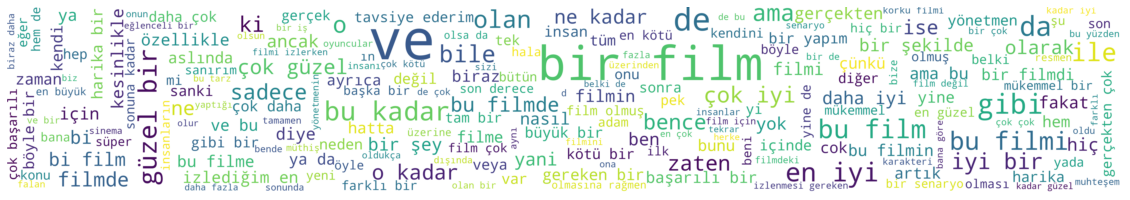

In [21]:
text = []
for i in df["comment"]:
    text.append(i)
text = ''.join(map(str, text)) 
wordcloud = WordCloud(width=6000, height=1000, max_font_size=300,background_color='white').generate(text)
plt.figure(figsize=(20,17))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [52]:
df.groupby("point").count().reset_index()

,point,comment,film_name
0,0,25234,25397
1,1,43000,43336


Film_name özelliği silinebilir.

In [53]:
df["point"].value_counts(normalize=True)

1    0.630498
0    0.369502
Name: point, dtype: float64

### Tf-idf Vectorization

### Train Test

In [24]:
df["comment"]=df["comment"].astype('U')

In [23]:
#!pip install xgboost

In [24]:
#!pip install gensim

In [60]:
pip show gensim

Name: gensim
Version: 4.1.2
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPL-2.1-only
Location: c:\users\asus\anaconda3\lib\site-packages
Requires: Cython, numpy, scipy, smart-open
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [14]:
import seaborn as sns
import re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import xgboost
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
#!pip install gensim
from nltk.tokenize import sent_tokenize, word_tokenize 
import gensim 
from gensim.models import Word2Vec,KeyedVectors
from sklearn import svm
sns.set(font_scale=1.4)
from warnings import filterwarnings
filterwarnings('ignore')

In [15]:
import matplotlib.pyplot as plt

In [16]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(df["comment"],
                                                                   df["point"], 
                                                                    random_state = 1)

In [27]:
train_x

11892    sıradan bir konu yönetmen farkıyla hiç sıkmada...
55798    gerçekten eğlenceli bir filmfakat kadrodaki o ...
43271    izleyip pişman olmak istiyorsanız izleyin deri...
3440     muhteşem bir filmdietkilendim ve çok beğendimf...
38284    sean connerynin roger mooredan daha genç olmas...
                               ...                        
49100    fragmanını ve klibini izlediğim kadarıyla güze...
20609                              izlenilebilir bir film 
21440    herkesin başına gelebilecek olayların filme al...
50057    bence sinemadaki birçok yapım arasında samimiy...
5192     abi gerçekten film süper oyuncu kadrosundan zi...
Name: comment, Length: 51549, dtype: object

In [65]:
train_y

11892    1
55798    1
43271    0
3440     1
38284    0
        ..
49100    1
20609    1
21440    1
50057    1
5192     1
Name: point, Length: 51549, dtype: int64

In [66]:
test_x

66600    hakkaten berbat bir filmdi ya üzüldüm verdigim...
1890     ya kimseyi bilmem ama ben bu tip filmleri çok ...
36084    yeterince komik  özellikle kardeslik temasi ko...
23242    milos forman guguk kuşunu izledikten sonra fav...
53074    sıkılmayacağınız temposu yüksek ama basit bir ...
                               ...                        
58648    bu kadro ve amerikan sinemasının  teknolojiyle...
21841        ben sıkıldım izlerken müzikleri dışında kötüy
5609     dikkat etmişmisinizdir bilmiyorum ama esas kız...
3551              şi mekanlar renkler oyunculuklar filmi k
2393     filmi kesinlikle tavsiye ederim ilk  dk zaten ...
Name: comment, Length: 17184, dtype: object

In [67]:
test_y

66600    0
1890     1
36084    1
23242    1
53074    0
        ..
58648    0
21841    0
5609     1
3551     1
2393     1
Name: point, Length: 17184, dtype: int64

In [68]:
test_y.value_counts(normalize=True)

1    0.633205
0    0.366795
Name: point, dtype: float64

**Word Level**

In [69]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)

TfidfVectorizer()

In [70]:
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [71]:
tf_idf_word_vectorizer.get_feature_names()[0:5]

['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa']

In [72]:
x_train_tf_idf_word.toarray()

MemoryError: Unable to allocate 85.3 GiB for an array with shape (51549, 222111) and data type float64

**Ngram Level**

In [28]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range = (2,3))
tf_idf_ngram_vectorizer.fit(train_x)

TfidfVectorizer(ngram_range=(2, 3))

In [29]:
x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(train_x)
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(test_x)

In [30]:
tf_idf_ngram_vectorizer.get_feature_names()[0:5]

['aa atma', 'aa atma sahnelerini', 'aa bak', 'aa bak kendi', 'aa bu']

**Characters Level**

In [27]:
tf_idf_chars_vectorizer = TfidfVectorizer(analyzer = "char", ngram_range = (2,3))
tf_idf_chars_vectorizer.fit(train_x)

TfidfVectorizer(analyzer='char', ngram_range=(2, 3))

In [28]:
x_train_tf_idf_chars = tf_idf_chars_vectorizer.transform(train_x)
x_test_tf_idf_chars = tf_idf_chars_vectorizer.transform(test_x)

## Machine Learning Algoritmaları

### Support Vector Machine

In [78]:
svm = svm.SVC(kernel='linear')

In [79]:
svm_model = svm.fit(x_train_tf_idf_ngram,train_y)
accuracy = model_selection.cross_val_score(svm_model, 
                                           x_test_tf_idf_ngram, 
                                           test_y, 
                                           cv = 10).mean()
y_pred=svm_model.predict(x_test_tf_idf_ngram)
print(metrics.classification_report(test_y,y_pred,digits=3))
print("Support Vector Machine N-GRAM TF-IDF Accuracy:", accuracy)

              precision    recall  f1-score   support

           0      0.798     0.609     0.691      6303
           1      0.801     0.911     0.852     10881

    accuracy                          0.800     17184
   macro avg      0.800     0.760     0.772     17184
weighted avg      0.800     0.800     0.793     17184

Support Vector Machine N-GRAM TF-IDF Accuracy: 0.7701361080466823


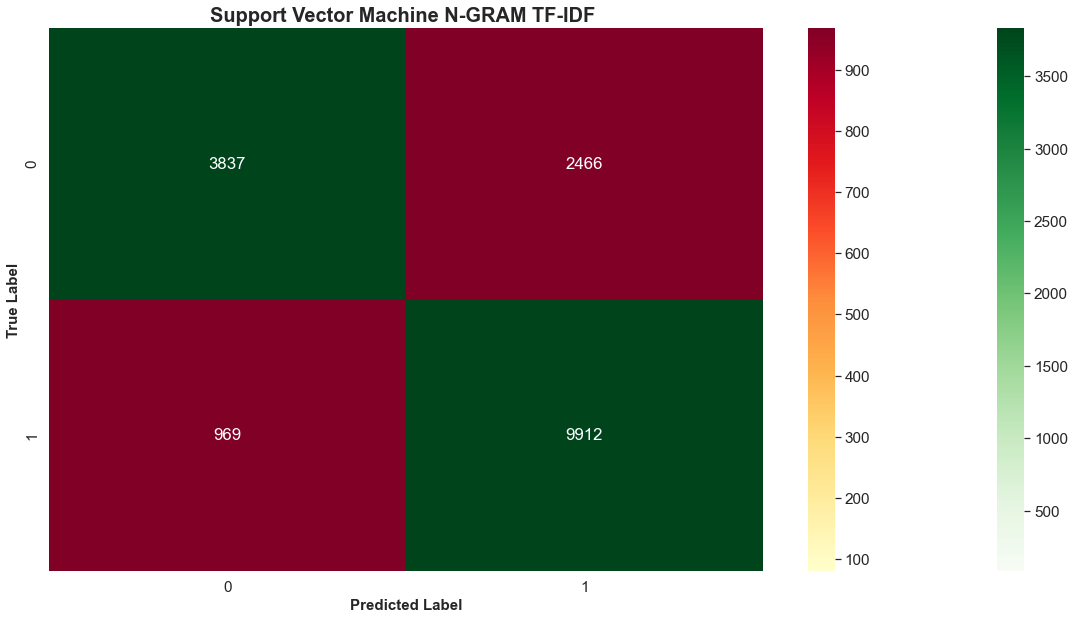

In [80]:
plt.figure(figsize=(20,10))
cm = confusion_matrix(test_y, y_pred)
class_label = [sorted(set(df["point"]))]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
off_diag_mask = np.eye(*df_cm.shape, dtype=bool)
sns.heatmap(df_cm,mask=~off_diag_mask, cmap='Greens', annot=True, fmt='d',vmax=80)
sns.heatmap(df_cm,mask=off_diag_mask, cmap='YlOrRd', annot=True, fmt='d',vmax=80)
plt.title("Support Vector Machine N-GRAM TF-IDF ",fontweight="bold",fontsize=20)
plt.xlabel("Predicted Label",fontweight="bold",fontsize=15)
plt.ylabel("True Label",fontweight="bold",fontsize=15)
plt.show()

In [ ]:
svm_model = svm.fit(x_train_tf_idf_chars,train_y)
accuracy = model_selection.cross_val_score(svm_model, 
                                           x_test_tf_idf_chars, 
                                           test_y, 
                                           cv = 10).mean()
y_pred=svm_model.predict(x_test_tf_idf_chars)
print(metrics.classification_report(test_y,y_pred,digits=3))
print("Support Vector Machine CHAR LEVEL TF-IDF Accuracy:", accuracy)

In [ ]:
plt.figure(figsize=(20,10))
cm = confusion_matrix(test_y, y_pred)
class_label = [sorted(set(df["point"]))]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
off_diag_mask = np.eye(*df_cm.shape, dtype=bool)
sns.heatmap(df_cm,mask=~off_diag_mask, cmap='Greens', annot=True, fmt='d',vmax=80)
sns.heatmap(df_cm,mask=off_diag_mask, cmap='YlOrRd', annot=True, fmt='d',vmax=80)
plt.title("Support Vector Machine CHAR LEVEL TF-IDF ",fontweight="bold",fontsize=20)
plt.xlabel("Predicted Label",fontweight="bold",fontsize=15)
plt.ylabel("True Label",fontweight="bold",fontsize=15)
plt.show()

## Naive Bayes

In [34]:
nb = naive_bayes.MultinomialNB()

In [36]:
nb_model = nb.fit(x_train_tf_idf_ngram,train_y)
accuracy = model_selection.cross_val_score(nb_model, 
                                           x_test_tf_idf_ngram, 
                                           test_y, 
                                           cv = 20).mean()
y_pred=nb_model.predict(x_test_tf_idf_ngram)
print(metrics.classification_report(test_y,y_pred,digits=3))
print("Naive Bayes N-GRAM TF-IDF Accuracy:", accuracy)

              precision    recall  f1-score   support

           0      0.939     0.255     0.401      6303
           1      0.697     0.990     0.818     10881

    accuracy                          0.721     17184
   macro avg      0.818     0.623     0.610     17184
weighted avg      0.785     0.721     0.665     17184

Naive Bayes N-GRAM TF-IDF Accuracy: 0.6849391531526654


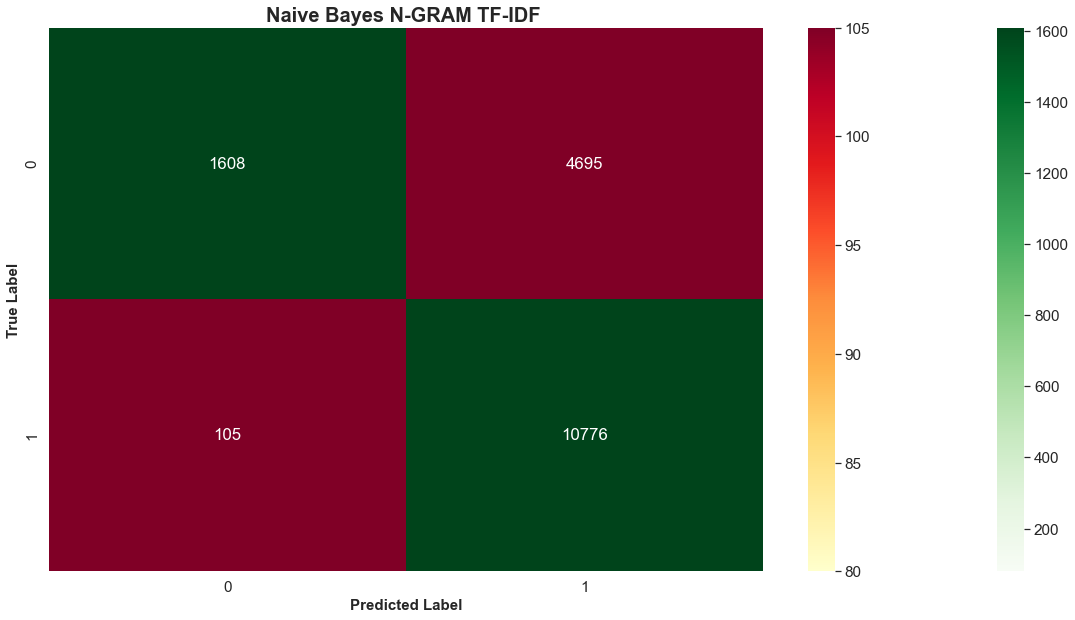

In [38]:
plt.figure(figsize=(20,10))
cm = confusion_matrix(test_y, y_pred)
class_label = [sorted(set(df["point"]))]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
off_diag_mask = np.eye(*df_cm.shape, dtype=bool)
sns.heatmap(df_cm,mask=~off_diag_mask, cmap='Greens', annot=True, fmt='d',vmax=80)
sns.heatmap(df_cm,mask=off_diag_mask, cmap='YlOrRd', annot=True, fmt='d',vmax=80)
plt.title("Naive Bayes N-GRAM TF-IDF ",fontweight="bold",fontsize=20)
plt.xlabel("Predicted Label",fontweight="bold",fontsize=15)
plt.ylabel("True Label",fontweight="bold",fontsize=15)
plt.show()

In [39]:
nb_model = nb.fit(x_train_tf_idf_chars,train_y)
accuracy = model_selection.cross_val_score(nb_model, 
                                           x_test_tf_idf_chars, 
                                           test_y, 
                                           cv = 10).mean()
y_pred=nb_model.predict(x_test_tf_idf_chars)
print(metrics.classification_report(test_y,y_pred,digits=3))
print("Naive Bayes CHAR LEVEL TF-IDF Accuracy:", accuracy)

              precision    recall  f1-score   support

           0      0.855     0.388     0.534      6303
           1      0.731     0.962     0.830     10881

    accuracy                          0.751     17184
   macro avg      0.793     0.675     0.682     17184
weighted avg      0.776     0.751     0.722     17184

Naive Bayes CHAR LEVEL TF-IDF Accuracy: 0.6819137408989848


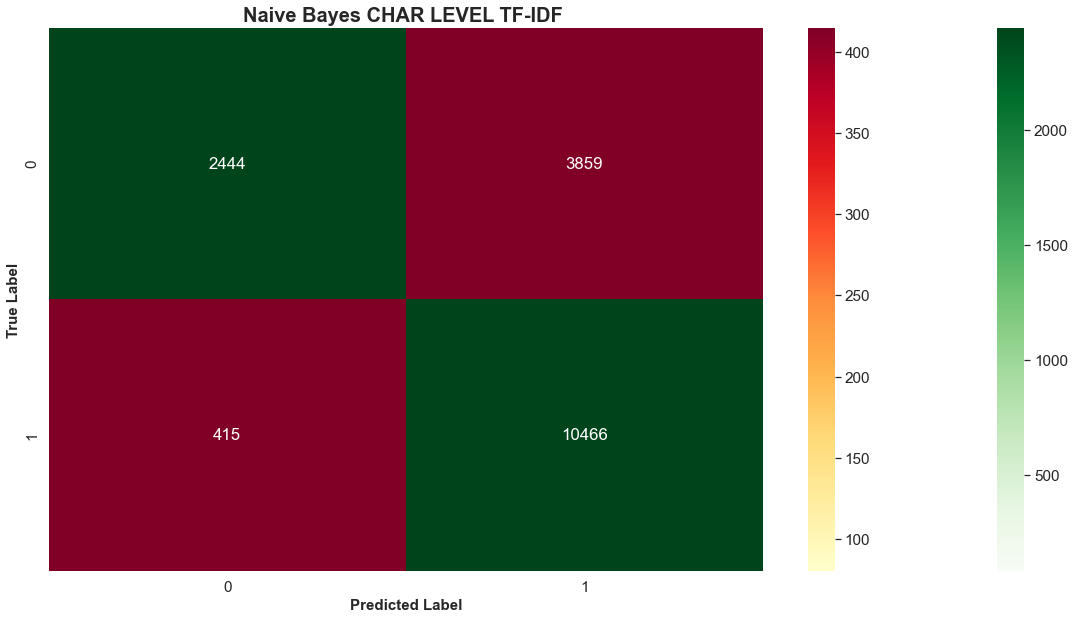

In [40]:
plt.figure(figsize=(20,10))
cm = confusion_matrix(test_y, y_pred)
class_label = [sorted(set(df["point"]))]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
off_diag_mask = np.eye(*df_cm.shape, dtype=bool)
sns.heatmap(df_cm,mask=~off_diag_mask, cmap='Greens', annot=True, fmt='d',vmax=80)
sns.heatmap(df_cm,mask=off_diag_mask, cmap='YlOrRd', annot=True, fmt='d',vmax=80)
plt.title("Naive Bayes CHAR LEVEL TF-IDF ",fontweight="bold",fontsize=20)
plt.xlabel("Predicted Label",fontweight="bold",fontsize=15)
plt.ylabel("True Label",fontweight="bold",fontsize=15)
plt.show()

## Random  Forest

In [41]:
rf = ensemble.RandomForestClassifier()

In [ ]:
rf_model = rf.fit(x_train_tf_idf_ngram,train_y)
accuracy = model_selection.cross_val_score(rf_model, 
                                           x_test_tf_idf_ngram, 
                                           test_y, 
                                           cv = 10).mean()
y_pred=rf_model.predict(x_test_tf_idf_ngram)
print(metrics.classification_report(test_y,y_pred,digits=3))
print("Random Forest N-GRAM TF-IDF Accuracy:", accuracy)

In [ ]:
plt.figure(figsize=(20,10))
cm = confusion_matrix(test_y, y_pred)
class_label = [sorted(set(df["Subject of inquiries"]))]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
off_diag_mask = np.eye(*df_cm.shape, dtype=bool)
sns.heatmap(df_cm,mask=~off_diag_mask, cmap='Greens', annot=True, fmt='d',vmax=80)
sns.heatmap(df_cm,mask=off_diag_mask, cmap='YlOrRd', annot=True, fmt='d',vmax=80)
plt.title("Random Forest N-GRAM TF-IDF",fontweight="bold",fontsize=20)
plt.xlabel("Predicted Label",fontweight="bold",fontsize=15)
plt.ylabel("True Label",fontweight="bold",fontsize=15)
plt.show()

In [ ]:
rf_model = rf.fit(x_train_tf_idf_chars,train_y)
accuracy = model_selection.cross_val_score(rf_model, 
                                           x_test_tf_idf_chars, 
                                           test_y, 
                                           cv = 10).mean()
y_pred=rf_model.predict(x_test_tf_idf_chars)
print(metrics.classification_report(test_y,y_pred,digits=3))
print("Random Forest CHAR LEVEL TF-IDF Accuracy:", accuracy)

In [ ]:
plt.figure(figsize=(20,10))
cm = confusion_matrix(test_y, y_pred)
class_label = [sorted(set(df["Subject of inquiries"]))]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
off_diag_mask = np.eye(*df_cm.shape, dtype=bool)
sns.heatmap(df_cm,mask=~off_diag_mask, cmap='Greens', annot=True, fmt='d',vmax=80)
sns.heatmap(df_cm,mask=off_diag_mask, cmap='YlOrRd', annot=True, fmt='d',vmax=80)
plt.title("Random Forest CHAR LEVEL TF-IDF",fontweight="bold",fontsize=20)
plt.xlabel("Predicted Label",fontweight="bold",fontsize=15)
plt.ylabel("True Label",fontweight="bold",fontsize=15)
plt.show()

### Logistic Regression

In [29]:
loj = linear_model.LogisticRegression()

In [30]:
loj_model = loj.fit(x_train_tf_idf_chars,train_y)
accuracy = model_selection.cross_val_score(loj_model, 
                                           x_test_tf_idf_chars, 
                                           test_y, 
                                           cv = 10).mean()
y_pred=loj_model.predict(x_test_tf_idf_chars)
print(metrics.classification_report(test_y,y_pred,digits=3))
print("Logistic Regression CHAR LEVEL TF-IDF Accuracy:", accuracy)

              precision    recall  f1-score   support

           0      0.778     0.658     0.713      6303
           1      0.818     0.891     0.853     10881

    accuracy                          0.806     17184
   macro avg      0.798     0.775     0.783     17184
weighted avg      0.803     0.806     0.802     17184

Logistic Regression CHAR LEVEL TF-IDF Accuracy: 0.7903862941133846


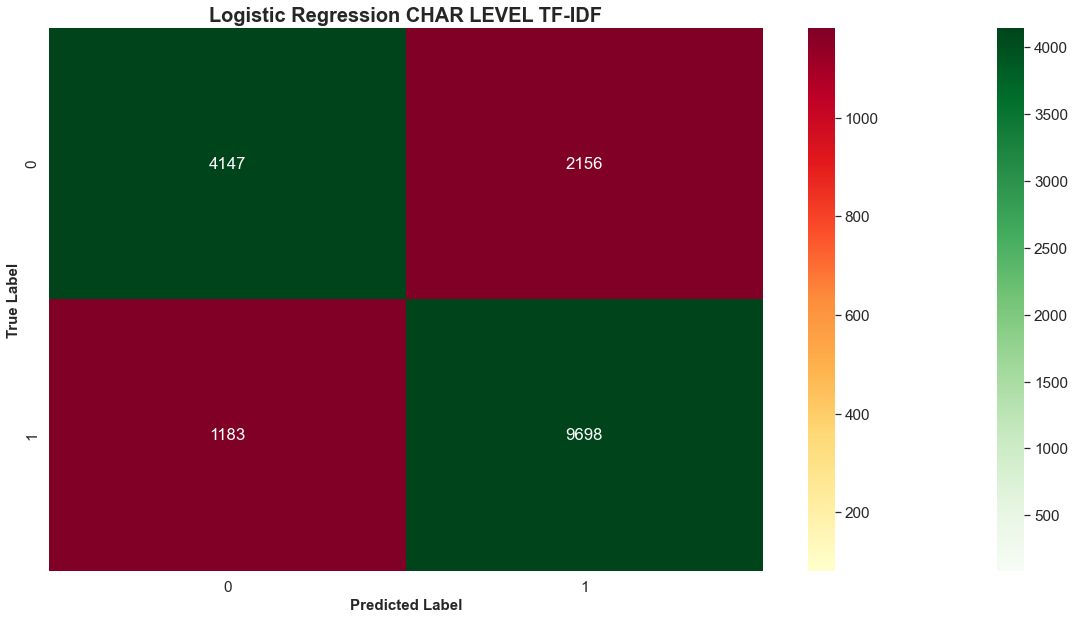

In [33]:
plt.figure(figsize=(20,10))
cm = confusion_matrix(test_y, y_pred)
class_label = [sorted(set(df["point"]))]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
off_diag_mask = np.eye(*df_cm.shape, dtype=bool)
sns.heatmap(df_cm,mask=~off_diag_mask, cmap='Greens', annot=True, fmt='d',vmax=80)
sns.heatmap(df_cm,mask=off_diag_mask, cmap='YlOrRd', annot=True, fmt='d',vmax=80)
plt.title("Logistic Regression CHAR LEVEL TF-IDF",fontweight="bold",fontsize=20)
plt.xlabel("Predicted Label",fontweight="bold",fontsize=15)
plt.ylabel("True Label",fontweight="bold",fontsize=15)
plt.show()

### XGBoost

In [35]:
xgb = xgboost.XGBClassifier()

In [36]:
xgb_model = xgb.fit(x_train_tf_idf_chars,train_y)
accuracy = model_selection.cross_val_score(xgb_model, 
                                           x_test_tf_idf_chars, 
                                           test_y, 
                                           cv = 10).mean()
y_pred=xgb_model.predict(x_test_tf_idf_chars)
print(metrics.classification_report(test_y,y_pred,digits=3))
print("XGBoost CHAR LEVEL TF-IDF Accuracy:", accuracy)

[15:12:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:17:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:20:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

en yüksek karakter level çıkıyor

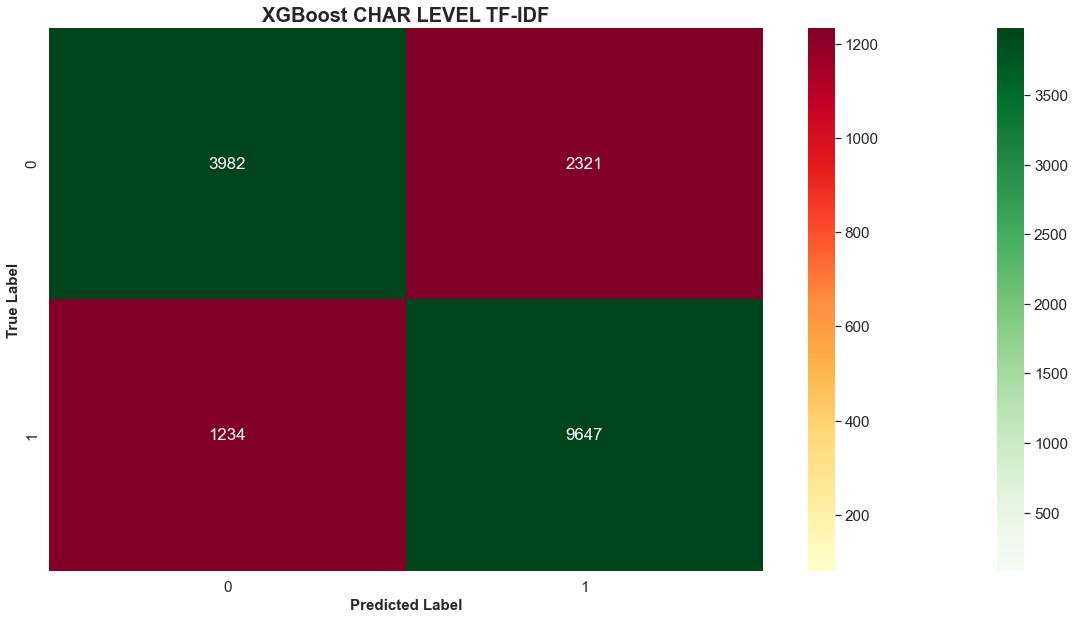

In [38]:
plt.figure(figsize=(20,10))
cm = confusion_matrix(test_y, y_pred)
class_label = [sorted(set(df["point"]))]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
off_diag_mask = np.eye(*df_cm.shape, dtype=bool)
sns.heatmap(df_cm,mask=~off_diag_mask, cmap='Greens', annot=True, fmt='d',vmax=80)
sns.heatmap(df_cm,mask=off_diag_mask, cmap='YlOrRd', annot=True, fmt='d',vmax=80)
plt.title("XGBoost CHAR LEVEL TF-IDF",fontweight="bold",fontsize=20)
plt.xlabel("Predicted Label",fontweight="bold",fontsize=15)
plt.ylabel("True Label",fontweight="bold",fontsize=15)
plt.show()

Artık modeli kurmak için girişimlerde bulunabiliriz. Etiketleri (points) ve yorumları (comments) ayırarak listeler içerisine alıyoruz.
Elimizdeki verilerin %80'i ile modeli kurup, %20'si ile modelimizi test edeceğiz. Bu sebepten dolayı öncelikle verinin boyutunun %80'inini alarak cutoff değişkenine atıyoruz. Ardından da cutoff değişkenine göre oluşturduğumuz target ve data listelerini, train ve test olarak ayırıyoruz.

In [7]:
target = df["point"].values.tolist()
data = df["comment"].values.tolist()

In [8]:
cutoff = int(len(data)*0.80)

In [9]:
X_train, X_test = data[:cutoff], data[cutoff:]
y_train, y_test = target[:cutoff], target[cutoff:]

Artık elimizdekileri tokenleştirebiliriz. Tokenleştirme işlemi yapılırken her yorum kelimelere ayrılacak. Kelime haznesindeki her kelimeye karşılık farklı bir sayı gelecek. İlk önce kelime haznemizde en fazla kaç tane kelime oluşsun bunu belirleyeceğiz. Bunun için num_words değişkenine 10.000 değerini veriyoruz. Bununla beraber en sık geçen 10.000 kelimeyi alacağız. Duygu Analizi yapacağımız için veri içerisindeki tüm kelimeleri almamıza gerek yok. Tokenleştirme işlemini “keras” kullanarak gerçekleştiriyoruz.

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
num_words = 10000
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(data)

AttributeError: 'float' object has no attribute 'lower'

In [46]:
tokenizer.word_index

{'bir': 1,
 've': 2,
 'film': 3,
 'bu': 4,
 'çok': 5,
 'filmi': 6,
 'de': 7,
 'ama': 8,
 'da': 9,
 'iyi': 10,
 'en': 11,
 'kadar': 12,
 'daha': 13,
 'filmin': 14,
 'için': 15,
 'güzel': 16,
 'gibi': 17,
 'o': 18,
 'ne': 19,
 'bi': 20,
 'olarak': 21,
 'filmde': 22,
 'ile': 23,
 'bence': 24,
 'her': 25,
 'ki': 26,
 'var': 27,
 'olan': 28,
 'ben': 29,
 'kötü': 30,
 'bile': 31,
 'değil': 32,
 'hiç': 33,
 'sonra': 34,
 'gerçekten': 35,
 'filme': 36,
 'ilk': 37,
 'son': 38,
 'yok': 39,
 'zaman': 40,
 'kesinlikle': 41,
 'biraz': 42,
 'başarılı': 43,
 'şey': 44,
 'tek': 45,
 'tavsiye': 46,
 'diye': 47,
 'sadece': 48,
 'büyük': 49,
 'olmuş': 50,
 'harika': 51,
 'böyle': 52,
 'ya': 53,
 'zaten': 54,
 'fazla': 55,
 'olduğunu': 56,
 'cok': 57,
 'olduğu': 58,
 'yine': 59,
 'tam': 60,
 'ise': 61,
 'biri': 62,
 'nasıl': 63,
 'izledim': 64,
 'ancak': 65,
 'senaryo': 66,
 'konu': 67,
 'aynı': 68,
 'sinema': 69,
 'farklı': 70,
 'özellikle': 71,
 'şekilde': 72,
 'fakat': 73,
 'önce': 74,
 'pek': 75,
 'ko

Tokenizer tanımladığımıza göre elimizdeki veriyi tokenleştirebiliriz.
Train ve test verisindeki tüm yorumları tokenler halinde bir değişken içerisinde saklayalım. Ardından da 1000. satırın nasıl gözüktüğünü kontrol edelim.

In [47]:
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)
print(X_train[1000])
print(X_train_tokens[1000])

film gerçekten bomba   çok komikti eğlenceli vakit geçirmek isteyen herkese öneririm  eddie murphy de gerçekten super oynamı
[3, 35, 3226, 5, 1858, 128, 202, 673, 873, 269, 1642, 3233, 3496, 7, 35, 1328, 8853]


In [50]:
print(X_train[200])
print(X_train_tokens[200])


çok etkileyici duygusal bir film oyuncular çok başarılı kaçırmamanızı tavsiye ederim
[5, 148, 350, 1, 3, 166, 5, 43, 46, 147]


Kelime haznesini sınırlandırdığımız için her kelimeye karşılık bir token bulunmayacak. Eğer kelime haznesinde değilse o kelime, yok sayılayacak.
Sinir ağlarında genellikle RNN ile oluşturduğumuz modellere belli boyutlarda inputlar veririz. Bizim verideki yorumlar hepsi farklı sayılardaki kelimelerden oluşmaktadır. Farklı sayılardaki kelimeleri RNN içerisine input olarak veremeyiz. Tüm yorumları aynı boyuta getirmemiz gerekir. Eğer yorum belirlediğimiz boyuttan düşük boyutta olursa 0 eklenecek. Eğer yorum belirlediğimiz boyuttan yüksekse belirli kısımları silerek kendi belirlediğimiz boyuta getireceğiz.
Öncelikle for döngüsü oluşturup veri setimizdeki her yorumun üzerinden tek tek geçeceğiz ve token sayısını alacağız. Liste üzerinde işlem yapmayı kolaylaştırmak amacıyla da listeyi numpy array’e dönüştüreceğiz.

In [51]:
num_tokens = [len(tokens) for tokens in X_train_tokens + X_test_tokens]

Her bir cümledeki token sayısı

In [52]:
num_tokens = np.array(num_tokens)

In [53]:
num_tokens

array([14, 47, 96, ..., 21,  4, 51])

Ortalama olarak bir yorumda kaç tane token olduğuna bakalım.

In [54]:
np.mean(num_tokens)

31.325767826226123

En fazla token bulunan yorumun token sayısına bakalım.

In [55]:
np.max(num_tokens)

3094

In [56]:
np.min(num_tokens)

0

Şimdi yorumların boyutlarını eşitleyeceğiz. Bunun için kendimiz bir boyut belirliyoruz. Kendimiz değer verebiliriz, en yüksek tokenli yorumun boyutunu kullanabiliriz ya da ortalamayı alabiliriz. Biz ise ortalamayı alıp 2 standart sapma ekleyerek elde edeceğiz.

In [57]:
max_tokens = np.mean(num_tokens) + (2*np.std(num_tokens))
max_tokens = int(max_tokens)
max_tokens

141

Elde ettiğimiz boyut yorumların yüzde kaçını kapsıyor bakalım.


In [58]:
num_tokens < max_tokens

array([ True,  True,  True, ...,  True,  True,  True])

In [59]:
np.sum(num_tokens < max_tokens)

66958

In [60]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9741754324705746

Train setindeki her yorumun boyutunu elde ettiğimiz boyuta getiriyoruz. İlk önce padding eklenecek veriyi giriyoruz. Ardından belirlediğimiz boyutu giriyoruz.


In [62]:
X_train_pad = pad_sequences(X_train_tokens, maxlen = max_tokens) 
X_test_pad = pad_sequences(X_test_tokens, maxlen = max_tokens)

print(X_train_pad.shape)
print(X_test_pad.shape)

(54986, 141)
(13747, 141)


Padding’i daha iyi görebilmek 800. yoruma bakalım.

In [63]:
np.array(X_train_tokens[800])

array([  41,   36, 1865,  416,   54, 1825,  480,  355,   80,   33])

Aynı yorumun padding uygulanmış haline bakalım.

In [65]:
X_train_pad[800]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   41,
         36, 1865,  416,   54, 1825,  480,  355,   80,   33])

In [64]:
X_train_pad[2000]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    5,   70,    1,    3,    4,
       5062, 4072,  852,    5,    5,   16,  527, 2371, 1106])

Tokenleri verip, stringi alabilmek için fonksiyon yazacağız. Bu şekilde elimizdeki tokenleri tekrar yoruma çevireceğiz. word_index içerisinde sözlük olarak kelimeler, kelimelerin sayısal olarak tokenleri bulunuyordu. word_index ile kelimeler ve sayıların yerini tersine çeviriyoruz. Artık bir sayıyı verdiğimiz zaman o sayıya karşılık gelen kelimeyi bulabileceğiz. Fonksiyon içerisinde sıfırlar kelimeye karşılık gelmediği için dahil etmiyoruz. Diğerlerini de liste içerisinde topluyoruz. Son olarak da bize yorumu çıktı olarak verecek.

In [48]:
idx = tokenizer.word_index

In [49]:
idx

{'bir': 1,
 've': 2,
 'film': 3,
 'bu': 4,
 'çok': 5,
 'filmi': 6,
 'de': 7,
 'ama': 8,
 'da': 9,
 'iyi': 10,
 'en': 11,
 'kadar': 12,
 'daha': 13,
 'filmin': 14,
 'için': 15,
 'güzel': 16,
 'gibi': 17,
 'o': 18,
 'ne': 19,
 'bi': 20,
 'olarak': 21,
 'filmde': 22,
 'ile': 23,
 'bence': 24,
 'her': 25,
 'ki': 26,
 'var': 27,
 'olan': 28,
 'ben': 29,
 'kötü': 30,
 'bile': 31,
 'değil': 32,
 'hiç': 33,
 'sonra': 34,
 'gerçekten': 35,
 'filme': 36,
 'ilk': 37,
 'son': 38,
 'yok': 39,
 'zaman': 40,
 'kesinlikle': 41,
 'biraz': 42,
 'başarılı': 43,
 'şey': 44,
 'tek': 45,
 'tavsiye': 46,
 'diye': 47,
 'sadece': 48,
 'büyük': 49,
 'olmuş': 50,
 'harika': 51,
 'böyle': 52,
 'ya': 53,
 'zaten': 54,
 'fazla': 55,
 'olduğunu': 56,
 'cok': 57,
 'olduğu': 58,
 'yine': 59,
 'tam': 60,
 'ise': 61,
 'biri': 62,
 'nasıl': 63,
 'izledim': 64,
 'ancak': 65,
 'senaryo': 66,
 'konu': 67,
 'aynı': 68,
 'sinema': 69,
 'farklı': 70,
 'özellikle': 71,
 'şekilde': 72,
 'fakat': 73,
 'önce': 74,
 'pek': 75,
 'ko

In [50]:
inverse_map = dict(zip(idx.values(), idx.keys()))

In [51]:
inverse_map

{1: 'bir',
 2: 've',
 3: 'film',
 4: 'bu',
 5: 'çok',
 6: 'filmi',
 7: 'de',
 8: 'ama',
 9: 'da',
 10: 'iyi',
 11: 'en',
 12: 'kadar',
 13: 'daha',
 14: 'filmin',
 15: 'için',
 16: 'güzel',
 17: 'gibi',
 18: 'o',
 19: 'ne',
 20: 'bi',
 21: 'olarak',
 22: 'filmde',
 23: 'ile',
 24: 'bence',
 25: 'her',
 26: 'ki',
 27: 'var',
 28: 'olan',
 29: 'ben',
 30: 'kötü',
 31: 'bile',
 32: 'değil',
 33: 'hiç',
 34: 'sonra',
 35: 'gerçekten',
 36: 'filme',
 37: 'ilk',
 38: 'son',
 39: 'yok',
 40: 'zaman',
 41: 'kesinlikle',
 42: 'biraz',
 43: 'başarılı',
 44: 'şey',
 45: 'tek',
 46: 'tavsiye',
 47: 'diye',
 48: 'sadece',
 49: 'büyük',
 50: 'olmuş',
 51: 'harika',
 52: 'böyle',
 53: 'ya',
 54: 'zaten',
 55: 'fazla',
 56: 'olduğunu',
 57: 'cok',
 58: 'olduğu',
 59: 'yine',
 60: 'tam',
 61: 'ise',
 62: 'biri',
 63: 'nasıl',
 64: 'izledim',
 65: 'ancak',
 66: 'senaryo',
 67: 'konu',
 68: 'aynı',
 69: 'sinema',
 70: 'farklı',
 71: 'özellikle',
 72: 'şekilde',
 73: 'fakat',
 74: 'önce',
 75: 'pek',
 76:

In [52]:
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token != 0]
    text = " ".join(words) # Kelimeler aralarında boşluk bırakılarak ard arda yazılacaktır.
    return text

In [53]:
tokens_to_string(X_train_tokens[350])

'bence gayet güzel bi filmdi her ne kadar kendi dışına yinede bence mükemmel bi oyunculuk ama her seyrettiğimde ayrı güzel bu filmide korku kategorisine hayret ettim doğrusu ne'

Sıra modeli kurmaya geldi. Embedding matrisini oluşturmadan önce, embedding matrisinin büyüklüğünü belirliyoruz. Her kelimeye karşılık gelen 50 uzunluğunda vektör oluşturuyoruz. Modele bir şey ekleyebilmek model.add kullanıyoruz.



num_words (10 bin) kelime sayılarıdır. 10 bin kelimeye karşılık gelen 50 uzunluğunda rastgele vektörler oluşturalım. Layer input aldığı zaman, input içerisindeki kelimelerin vektörlerini bir sonraki layer’a gönderecektir. embedding_layer’ın output’u, bir sonraki layer’ın input’u olacak.

Yinelenen sinir ağımızı (RNN) oluşturuyoruz. Yinelenen sinir ağını oluşturmak GRU kullanacağız. model.add(GRU()) bu şekilde de kullanılabilir. units, GRU değerimizin nöron sayısıdır. Bu layer’da 16 tane output verilecek. return_sequence = True, output olarak sequences tamamı döndürülecek. Eğer False olsaydı sadece son output döndürülürdü. Bir sonraki layer’a GRU ekleyeceğimiz için buna True demek zorundayız. Eğer bir sonraki layer bir nörondan oluşsaydı False girerdik. Sigmoid ile output’u [0,1] arasına sıkıştırıyoruz.

In [54]:
embedding_size = 50
model = Sequential()
model.add(Embedding(input_dim = num_words, output_dim = embedding_size, input_length = max_tokens, name = "embedding_layer"))

In [55]:
model.add(GRU(units = 16, return_sequences = True))
model.add(GRU(units = 8, return_sequences = True))
model.add(GRU(units = 4))
model.add(Dense(1, activation = "sigmoid"))

Modeli kurduk. Modelin eğitimine dair optimizasyon algoritması belirleyeceğiz. Bunun için Adam algoritmasını kullanacağız.

Optimizasyon algoritmasını belirledikten sonra, modelimizi derliyoruz. Sadece iki sınıf olduğu için de “binary_crossentropy” kullanacağız.

In [56]:
optimizer = Adam(lr = 1e-3)
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding)  (None, 141, 50)          500000    
                                                                 
 gru (GRU)                   (None, 141, 16)           3264      
                                                                 
 gru_1 (GRU)                 (None, 141, 8)            624       
                                                                 
 gru_2 (GRU)                 (None, 4)                 168       


C:\Users\asus\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 504,061
Trainable params: 504,061
Non-trainable params: 0
_________________________________________________________________


Eğitime başlıyoruz. Eğitimden kaç defa geçeceğine epochs parametresi ile karar veriyoruz.

In [57]:
X_train_pad = np.array(X_train_pad)
y_train = np.array(y_train)

model.fit(X_train_pad, y_train, epochs = 5, batch_size = 256)

Epoch 1/5
215/215 [==============================] - 86s 334ms/step - loss: 0.5201 - accuracy: 0.7594
Epoch 2/5
215/215 [==============================] - 71s 329ms/step - loss: 0.4020 - accuracy: 0.8330
Epoch 3/5
215/215 [==============================] - 71s 330ms/step - loss: 0.3671 - accuracy: 0.8550
Epoch 4/5
215/215 [==============================] - 68s 317ms/step - loss: 0.3463 - accuracy: 0.8661
Epoch 5/5
215/215 [==============================] - 65s 303ms/step - loss: 0.3294 - accuracy: 0.8773


Epochs = 20 yapalım.

In [58]:
model.fit(X_train_pad, y_train, epochs = 20, batch_size = 256)

Epoch 1/20
215/215 [==============================] - 67s 312ms/step - loss: 0.3076 - accuracy: 0.8902
Epoch 2/20
215/215 [==============================] - 71s 330ms/step - loss: 0.2870 - accuracy: 0.9020
Epoch 3/20
215/215 [==============================] - 69s 323ms/step - loss: 0.2661 - accuracy: 0.9133
Epoch 4/20
215/215 [==============================] - 71s 332ms/step - loss: 0.2485 - accuracy: 0.9221
Epoch 5/20
215/215 [==============================] - 70s 325ms/step - loss: 0.2368 - accuracy: 0.9285
Epoch 6/20
215/215 [==============================] - 63s 291ms/step - loss: 0.2216 - accuracy: 0.9356
Epoch 7/20
215/215 [==============================] - 66s 307ms/step - loss: 0.2088 - accuracy: 0.9410
Epoch 8/20
215/215 [==============================] - 71s 330ms/step - loss: 0.2021 - accuracy: 0.9440
Epoch 9/20
215/215 [==============================] - 71s 331ms/step - loss: 0.1980 - accuracy: 0.9455
Epoch 10/20
215/215 [==============================] - 70s 327ms/step - l

Test setindeki ilk 1000 yorum için tahminde bulunuyoruz. Bu tahminler bir matrisin sütunu olarak atanacaktır. Her satırda bir yorumun tahmin değeri bulunacaktır. Bu elemanlarla işlem yapmayı kolaylaştırabilmek için sütunu satıra çevireceğiz. Böylece elimizde tahmin değerlerini gösterecek bir vektör elde edeceğiz. Vektör üzerinde işlem yapmak daha kolaydır. Sütunu satıra çevirebilmemiz için matrisin transpozunu alıyoruz.

In [59]:
y_pred = model.predict(X_test_pad[0:1000])
y_pred = y_pred.T[0]

In [60]:
y_pred

array([0.17062044, 0.02319539, 0.02332443, 0.9434839 , 0.0280208 ,
       0.96571183, 0.965565  , 0.96582574, 0.96612084, 0.9645438 ,
       0.02465254, 0.9661206 , 0.96619177, 0.95407534, 0.9661565 ,
       0.9660773 , 0.8080927 , 0.58904386, 0.03790554, 0.9660963 ,
       0.96551013, 0.05514953, 0.96596587, 0.9661561 , 0.9660309 ,
       0.23519671, 0.96610814, 0.9661825 , 0.9661575 , 0.9660592 ,
       0.1747913 , 0.03939223, 0.06560189, 0.9660903 , 0.02227426,
       0.90619373, 0.02794653, 0.02412161, 0.03013751, 0.9492874 ,
       0.03072605, 0.02375197, 0.02865073, 0.9646013 , 0.2938763 ,
       0.96563864, 0.96595585, 0.08684459, 0.96572924, 0.9661269 ,
       0.8131856 , 0.96615136, 0.9659729 , 0.96619356, 0.95168245,
       0.96435606, 0.966174  , 0.86972845, 0.8616799 , 0.96576047,
       0.96443844, 0.95360744, 0.959753  , 0.0219166 , 0.96609765,
       0.05001903, 0.96617186, 0.03147355, 0.9661542 , 0.03852123,
       0.96072817, 0.02322823, 0.9616606 , 0.96611786, 0.96549

Elimizdeki tahmin değerlerini gerçekleri ile karşılaştırarak hangi yorumlarda yanlış olduğunu göreceğiz. Elimizdeki tahmin değerleri 0.5'ten büyükse 1, küçükse 0 yapacağız. Böylece 0 ve 1'lerden oluşan bir vektör elde edeceğiz. Elde ettiğimiz vektörü etiketlerle karşılaştıracağız.


In [61]:
cls_pred = np.array([1.0 if p > 0.5 else 0.0 for p in y_pred])
cls_true = np.array(y_test[0:1000])

Elimizdeki iki vektörü karşılaştıracağız. Yanlış tahminlerin indexlerini alalım.

In [62]:
incorrect = np.where(cls_pred != cls_true)
incorrect = incorrect[0]
incorrect

array([  3,   4,   6,   7,   9,  12,  13,  14,  15,  17,  23,  41,  44,
        50,  57,  59,  71,  76,  78,  85,  96,  98, 100, 105, 108, 109,
       110, 113, 119, 123, 124, 126, 127, 128, 129, 135, 140, 141, 148,
       149, 151, 154, 159, 170, 176, 178, 182, 183, 185, 192, 199, 200,
       201, 202, 204, 208, 209, 210, 211, 212, 213, 214, 215, 217, 218,
       219, 226, 229, 232, 234, 241, 246, 249, 258, 259, 263, 264, 265,
       267, 268, 270, 271, 277, 283, 287, 288, 290, 291, 292, 293, 295,
       296, 298, 299, 300, 306, 312, 313, 321, 323, 326, 344, 347, 350,
       360, 361, 362, 370, 371, 374, 376, 381, 382, 386, 388, 389, 392,
       394, 398, 399, 401, 403, 404, 405, 407, 408, 409, 410, 411, 412,
       413, 419, 422, 428, 432, 434, 436, 438, 440, 451, 458, 459, 461,
       462, 463, 469, 474, 476, 477, 481, 483, 486, 489, 490, 491, 495,
       496, 508, 513, 514, 515, 516, 518, 519, 524, 530, 531, 532, 533,
       544, 545, 546, 549, 561, 562, 563, 566, 572, 573, 574, 57

1000 tane yorumdan kaç tanesinin yanlış tahmin edildiğine bakalım.

In [63]:
len(incorrect)

285

Yanlış bilinen yorumlardan bir yorumun indexini alarak yoruma bakalım.

In [64]:
idx = incorrect[10]
X_test[idx]

'robert ludlumun romanları gerçekten sürükleyiciydibourne serisi sinamada bunu kanıtladıyazarın i̇kinci dünya savaşı ve özelliklede nazileri konu alan kitaplarıda çok güzeldirbu filmi henüz izleme fırsatımız olmadı ama tom cruisedan nasıl bir rus ajanı olur o tartışılı'

Modelimizin bu yoruma nasıl tahminde bulunduğuna bakalım.

In [65]:
y_pred[idx]

0.9661561

Modelimiz yorumu olumlu tahmin etmiş, doğrusuna bakalım.

In [66]:
cls_true[idx]

0.0